<a href="https://colab.research.google.com/github/howsam/Building-a-ChatGPT-like-Model-from-Scratch/blob/main/2_Train_Eval_Gen_LLM_specific_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <font color='#FFE15D'><b>💎 Train, Evaluate, and Generate Functions (LLM-specific) </b></font><font color='#FF0B55'><b>[Walkthrough]</b></font>

# 🔴 **Environment Setup**

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


## 🟠 `pip`

In [2]:
!pip install -q datasets torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.3 MB/s eta 0:00:00


# 🔴 **Import**

In [3]:
import os
import sys
import time
import math
import json
import random
from tqdm import tqdm
from pprint import pprint
from itertools import cycle
from termcolor import colored
from IPython.display import HTML
from dataclasses import dataclass
from prettytable import PrettyTable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import load_dataset
from tokenizers import Tokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchmetrics import MeanMetric

# 🔴 **Utils**

In [4]:
def prepare_data(tokens, seq_len):
    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]
    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [6]:
# Benchmarking function
def calculate_time(model, x, num_runs=10):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(num_runs):
        model(x)
    torch.cuda.synchronize()
    return (time.time() - start) / num_runs

# 🔴 **Init**

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
seq_len = 128 # Desired sequence length for each row

# 🔴 **Dataset**

In [ ]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [12]:
tokenizer = Tokenizer.from_file("bpe-tokenizer_tinystories.json")
tokenizer

Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[{"id":0, "content":"|<unk>|", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":1, "content":"<|endoftext|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}], normalizer=None, pre_tokenizer=ByteLevel(add_prefix_space=False, trim_offsets=True, use_regex=True), post_processor=TemplateProcessing(single=[SpecialToken(id="<|endoftext|>", type_id=0), Sequence(id=A, type_id=0)], pair=[Sequence(id=A, type_id=0), Sequence(id=B, type_id=1)], special_tokens={"<|endoftext|>":SpecialToken(id="<|endoftext|>", ids=[1], tokens=["<|endoftext|>"])}), decoder=ByteLevel(add_prefix_space=True, trim_offsets=True, use_regex=True), model=BPE(dropout=None, unk_token="|<unk>|", continuing_subword_prefix=None, end_of_word_suffix=None, fuse_unk=False, byte_fallback=False, ignore_merges=False, vocab={"|<unk>|":0, "<|endoftext|>":1, "!":2, """:3, "#":4, "$":5,

In [13]:
# Load tokens from pytorch file
train_token_ids = torch.load('tokenized-train-samples_vocab-10k.pt')
valid_token_ids = torch.load('tokenized-valid-samples_vocab-10k.pt')

print("📊 Number of Tokens")
print(f"🔹 Train: {len(train_token_ids):,} tokens")
print(f"🔹 Valid: {len(valid_token_ids):,} tokens")

📊 Number of Tokens
🔹 Train: 464,965,814 tokens
🔹 Valid: 4,673,588 tokens


In [14]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample.long()#[:-1], sample[1:]

# 🔴 **Model**

## 🟠 Multi Head Attention

In [15]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_size = self.n_embd // self.n_head

        self.qkv_proj = nn.Linear(self.n_embd, 3*self.n_embd, bias=False)
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)
        self.c_proj.residual = True

    def forward(self, x):
        B, T, C = x.shape
        # QKV linear
        q, k, v = self.qkv_proj(x).view(B, T, 3*self.n_head, self.head_size).transpose(1, 2).chunk(3, dim=-3)
        # Scaled Dot Product Attention using pytorch
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # Reshape and final projection
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

## 🟠 Feed Forward (MLP)

In [16]:
class FeedForward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.f_expnd = config.f_expnd

        self.up_proj = nn.Linear(self.n_embd, int(self.f_expnd*self.n_embd), bias=False)
        self.down_proj = nn.Linear(int(self.f_expnd*self.n_embd), self.n_embd, bias=False)
        self.down_proj.residual = True

    def forward(self, x):
        return self.down_proj(F.gelu(self.up_proj(x)))

## 🟠 Decoder Block

In [17]:
class DecoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        # Multi Head Attention
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mha = MultiHeadAttention(config)
        # Feed Forward Neural Network
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

## 🟠 GPT

In [18]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # Token embedding
        self.wpe = nn.Embedding(config.max_seq_len, config.n_embd) # Position embedding
        self.decoders = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]) # Decoders
        self.lnf = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Classifier
        self.lm_head.weight = self.wte.weight # Weight tying

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            if hasattr(module, 'residual'):
                std *= (2*self.config.n_layer)**-0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx):
        B, T = idx.shape
        # Token Embedding + Position Embedding
        x = self.wte(idx) + self.wpe(torch.arange(T, device=device))
        # Decoders
        for decoder in self.decoders:
            x = decoder(x)
        # Classifier
        x = self.lnf(x)
        logits = self.lm_head(x)
        return logits

## 🟠 Config

In [19]:
@dataclass
class GPTConfig:
    vocab_size: int = 50257 # number of tokens
    max_seq_len: int = 1024 # max sequence length
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension
    f_expnd: int = 4 # expansion factor in mlp

# 🔴 **Functions ⚙️**

## 🟠 Temp

In [ ]:
torch.manual_seed(1337)

seq_len = 128
train_set = TinyStoriesDataset(train_token_ids, seq_len)
valid_set = TinyStoriesDataset(valid_token_ids, seq_len)

batch_size = 192
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)#, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, pin_memory=True)#, num_workers=4)

print(f"📊 Number of Batches")
print(f"🔹 Train: {len(train_loader):,} batches")
print(f"🔹 Valid: {len(valid_loader):,} batches")

📊 Number of Batches
🔹 Train: 18,773 batches
🔹 Valid: 189 batches


In [ ]:
model = GPT(
    GPTConfig(
        max_seq_len=256,
        vocab_size=10_000,
        n_embd=128,
        n_layer=8,
        n_head=16
        )
    ).to(device)

print(model)
num_trainable_params(model)

GPT(
  (wte): Embedding(10000, 128)
  (wpe): Embedding(256, 128)
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=False)
        (c_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=128, out_features=512, bias=False)
        (down_proj): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (lnf): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=10000, bias=False)
)


2.889984

In [ ]:
learning_rate = 6e-4
weight_decay = 0.1
use_fused = True

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.95),
    weight_decay=weight_decay,
    fused=use_fused
    )

## 🟠 Logger

In [ ]:
# Logger class for saving and plotting training logs
class Logger:
    """
    Manages training history logging, saving to disk, and plotting learning curves.
    """
    def __init__(self, log_dir='logs', run_name='default_run'):
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        self.run_name = run_name
        self.history = {
            'train_loss': [],
            'valid_loss': [],
            'best_loss_valid': float('inf'),
            'seen_tokens': []
        }

    def log(self, train_loss, valid_loss, seen_tokens):
        self.history['train_loss'].append(train_loss)
        self.history['valid_loss'].append(valid_loss)
        self.history['seen_tokens'].append(seen_tokens)

    def save(self):
        # Save history
        file_path = os.path.join(self.log_dir, f'{self.run_name}.json')
        with open(file_path, 'w') as f:
            json.dump(self.history, f, indent=4)
        # Save best model and optimizer
        current_loss_valid = self.history['valid_loss'][-1]
        if current_loss_valid < self.history['best_loss_valid']:
            log = dict(model=model.state_dict(), optimizer=optimizer)
            torch.save(log, f'{self.log_dir}/best-model.pt')
            self.history['best_loss_valid'] = current_loss_valid
            print("✅ Model Saved!")

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['seen_tokens'], self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['seen_tokens'], self.history['valid_loss'], label='Valid Loss')
        plt.xlabel('Seen Tokens')
        plt.ylabel('Loss')
        plt.title(f'Training Curve: {self.run_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, f'{self.run_name}_curve.png'))
        plt.show()

## 🟠 Train ➰

In [ ]:
# Trainer class to manage model training, evaluation and reporting
class LLMTrainer:
    """
    Trainer handles training loops, periodic evaluation, logging, and sample generation.
    """
    def __init__(self, model, optimizer, train_loader, valid_loader,
                 loss_fn=F.cross_entropy, device='cuda',
                 total_tokens=10_000_000, log_interval_tokens=1_000_000,
                 generation=None):

        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.loss_fn = loss_fn
        self.device = device

        self.seen_tokens = 0
        self.total_tokens = total_tokens
        self.token_eval_counter = 0
        self.log_interval_tokens = log_interval_tokens

        self.logger = Logger(log_dir='logs', run_name='gpt2_tinystories')
        self._print_config_summary()

        self.generation = generation

    def train(self):
        """
        Main training loop that stops when total token count is reached.
        """
        # # Initial evaluation before any training
        # initial_loss = self.evaluate()
        # self.logger.log(initial_loss, initial_loss, 0)
        # print(f"👶 [Initial] Train Loss (Untrained Model): {initial_loss:.4f}\n")

        loss_train = MeanMetric()
        self.model.train()
        train_iter = cycle(self.train_loader)

        batches = 0
        total_time_elapsed = 0
        start_time = time.time()

        with tqdm(total=self.total_tokens, desc="Training", unit="t") as pbar:
            while self.seen_tokens < self.total_tokens:
                # Get inputs
                inputs = next(train_iter).to(self.device)
                # Forward pass
                logits = self.model(inputs[:, :-1])
                # Calculate loss
                loss = self.loss_fn(logits.view(-1, logits.shape[-1]), inputs[:, 1:].flatten())
                # Backward pass
                loss.backward()
                # Clip gradients
                nn.utils.clip_grad.clip_grad_norm_(self.model.parameters(), max_norm=1.)
                # Update model
                self.optimizer.step()
                self.optimizer.zero_grad()
                # Calc running loss
                loss_train.update(loss.item(), inputs.shape[0])

                num_tokens_this_batch = inputs[:, :-1].numel()
                self.seen_tokens += num_tokens_this_batch
                self.token_eval_counter += num_tokens_this_batch
                batches += 1
                elapsed = time.time() - start_time
                batches_per_sec = batches / elapsed

                pbar.set_postfix({
                    "B/S": f"{batches_per_sec:.2f}",
                    "Loss": f"{loss_train.compute().item():.4f}",
                    "LR": f"{self.optimizer.param_groups[0]['lr']:.2e}",
                })
                pbar.update(num_tokens_this_batch)

                if (self.token_eval_counter >= self.log_interval_tokens) or (self.seen_tokens >= self.total_tokens):
                    # Evaluate
                    loss_valid = self.evaluate()
                    print(f"\nValid Loss: {loss_valid:.4f}")
                    # Log
                    self.logger.log(loss_train.compute().item(), loss_valid, self.seen_tokens)
                    self.logger.save()
                    # Generate
                    if self.generation:
                        self.generate()
                    # Reset
                    self.token_eval_counter = 0
                    batches = 0
                    start_time = time.time()

        self.logger.plot()

    def evaluate(self):
        """
        Evaluate model on validation set.
        """
        loss_valid = MeanMetric()
        self.model.eval()
        with torch.no_grad():
            for inputs in self.valid_loader:
                inputs = inputs.to(self.device)
                logits = self.model(inputs[:, :-1])
                loss = self.loss_fn(logits.view(-1, logits.shape[-1]), inputs[:, 1:].flatten())
                loss_valid.update(loss.item(), inputs.shape[0])
        return loss_valid.compute().item()

    def generate(self):
        """
        Generate and print text samples from the model.
        """
        generated_texts = []
        for prompt in self.generation.prompts:
            gen_text = generate(
                self.model, self.generation.tokenizer, prompt,
                n_rep=self.generation.n_rep,
                max_seq_len=self.generation.max_seq_len,
                T=self.generation.T, top_k=self.generation.top_k,
                seed=self.generation.seed)
            generated_texts.append(gen_text)
        # TODO: Save
        # Print
        # print(150*'.')
        # item = 0
        # prompt0 = self.generation.prompts[item]
        # for gen_text in generated_texts[item]:
        #     print(colored(f"\n{prompt0}", "green"), end=' ')
        #     print(colored(f"{gen_text[len(prompt0):]}", "cyan"))
        #     print(150*'.')
        # print()
        item = 0
        prompt0 = self.generation.prompts[item]
        gen_text0 = generated_texts[item][0]
        print(colored(f"\n{prompt0}", "green"), end=' ')
        print(colored(f"{gen_text0[len(prompt0):]}", "cyan"))
        print()

    def _print_config_summary(self):
        """
        Print a summary table of training configuration.
        """
        table = PrettyTable()
        table.title = "Training Configuration Summary"
        table.field_names = ["Component", "Details"]
        # Model
        table.add_row(["Model Type", str(self.model.config).replace("Config", "")])
        # Optimizer
        optimizer_name = self.optimizer.__class__.__name__
        optimizer_params = ', '.join([f"{k}={v}" for k, v in self.optimizer.defaults.items() if k in ["lr", "betas", "weight_decay", "fused"]])
        optimizer_display = f"{optimizer_name}({optimizer_params})"
        table.add_row(["Optimizer", optimizer_display])
        # Parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        te_params = self.model.wte.weight.numel()
        table.add_row(["Total Parameters (Tr+TE)", f"{total_params:,} ({total_params-te_params:,}+{te_params:,})"])

        table.add_row(["Loss Function", self.loss_fn.__name__ if hasattr(self.loss_fn, '__name__') else str(self.loss_fn)])
        table.add_row(["Batch Shape", f"{self.train_loader.batch_size}x{self.train_loader.dataset[0].shape[-1]-1}"])
        table.add_row(["Device", self.device])
        table.add_row(["Max Tokens", f"{self.total_tokens:,}"])
        table.add_row(["Log Interval Tokens", f"{self.log_interval_tokens:,}"])
        print(table)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
@dataclass
class GenerationConfig:
    tokenizer: Tokenizer
    prompts: list[str]
    T: float = 0.9
    max_seq_len: int = 128
    top_k: int = 10
    n_rep: int = 3
    seed: int = 42


trainer = LLMTrainer(
    model, optimizer, train_loader, valid_loader,
    total_tokens=100_000, log_interval_tokens=50_000,
    generation=GenerationConfig(tokenizer=tokenizer, prompts=["In last", "One day"]))

+----------------------------------------------------------------------------------------------------------------+
|                                         Training Configuration Summary                                         |
+--------------------------+-------------------------------------------------------------------------------------+
|        Component         |                                       Details                                       |
+--------------------------+-------------------------------------------------------------------------------------+
|        Model Type        | GPT(vocab_size=10000, max_seq_len=256, n_layer=8, n_head=16, n_embd=128, f_expnd=4) |
|        Optimizer         |          AdamW(lr=0.0006, betas=(0.9, 0.95), weight_decay=0.1, fused=True)          |
| Total Parameters (Tr+TE) |                           2,889,984 (1,609,984+1,280,000)                           |
|      Loss Function       |                                    cross_entropy   

Training:  74%|████████████████████▋       | 73728/100000 [01:20<00:22, 1164.57t/s, B/S=0.04, Loss=8.3657, LR=6.00e-04]


Valid Loss: 8.1811
✅ Model Saved!

In last .
 One. They hard the fun. it's a a a decided a. Then. flew can not. the,. They't,, she, she,'s not, a. flew hard, but and. He't decided. She.
His fun.



His a,'s not.

 it decided and can,'s can bird.

Her a bird can, and the, decided. carefully. You a to.

 She a fun can the the and. carefully to flowers bird and and the.I. He can can to and. They.






Training: 122880t [05:24, 348.69t/s, B/S=0.13, Loss=8.2721, LR=6.00e-04]


Valid Loss: 7.9985
✅ Model Saved!


Training: 122880t [09:51, 207.83t/s, B/S=0.13, Loss=8.2721, LR=6.00e-04]


In last .
 it. They bird bird decided. You bird bird can can but a..
 and the decided. the,. They bird, and fun, decided to fun bird's decided. Then hard, a and. HeI't. She.
Lily decided.



The can canI but.

 find a, a the to decidedI.

 decided a decided, can and, and fun. You. You a to.
The bird the bird bird the the and. Then bird'tI a and,.I. He can canI can. They.






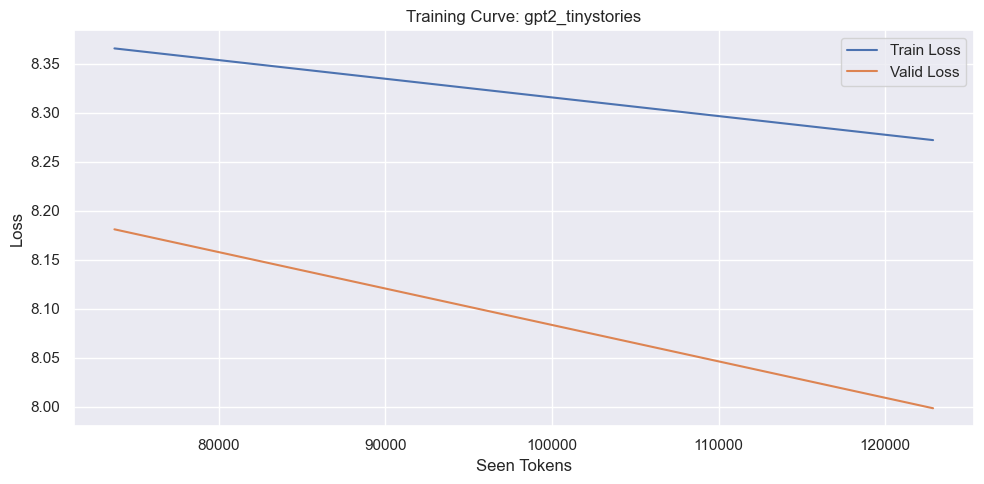

In [ ]:
trainer.train()

### 🟡 Temp

In [ ]:
from torch.utils.data import TensorDataset
loader = DataLoader(TensorDataset(torch.arange(4)), batch_size=2)

In [ ]:
from itertools import cycle
iterr = cycle(loader)

In [ ]:
next(iterr)

[tensor([0, 1])]

In [ ]:
with tqdm(total=100, desc="Training", unit='t') as pbar:
    for i in range(10):
        time.sleep(0.1)
        pbar.set_postfix({'loss': torch.randn(1).item()})
        pbar.update(10)

Training: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.63t/s, loss=0.21]


In [ ]:
from prettytable import PrettyTable

# Create a table
table = PrettyTable()

# Add columns
table.field_names = ["Name", "Position", "Age"]

# Add rows
table.add_row(["Alice", "Manager", 35])
table.add_row(["Bob", "Data Analyst", 29])
table.add_row(["Charlie", "Engineer", 32])

# Print the table
print(table)

+---------+--------------+-----+
|   Name  |   Position   | Age |
+---------+--------------+-----+
|  Alice  |   Manager    |  35 |
|   Bob   | Data Analyst |  29 |
| Charlie |   Engineer   |  32 |
+---------+--------------+-----+


## 🟠 Generate

In [ ]:
max_seq_len = 128

prompt = 'In last'
tokens = tokenizer.encode(prompt).ids
tokens = torch.tensor(tokens, dtype=torch.int, device=device).unsqueeze(0)
print(tokens)

model.eval()
with torch.no_grad():
    for i in range(max_seq_len):
        logits = model(tokens)
        scores = logits[0, [-1]].softmax(dim=-1)
        idx = scores.argmax(keepdims=True)
        tokens = torch.cat((tokens, idx), dim=-1)

tokenizer.decode(tokens[0].tolist())

tensor([[   1, 2201, 2220]], device='cuda:0', dtype=torch.int32)


'In last, there was a little girl named Lily. She loved to play with her friends. One day, she saw a big, a big, a little girl named Lily. She was very happy and wanted to play with her mom.\n\n"I\'m sorry, but I\'m sorry. I\'m sorry, but you have to be careful. I\'m sorry. I\'m sorry, but you want to be careful. I\'m sorry. I\'m sorry. I\'m sorry, I\'m sorry. I\'m sorry. I\'m sorry. I\'m sorry. I\'m sorry. I\'m sorry. I\'m sorry. I\'m sorry,'

### 🟡 `temperature` in `softmax`

Temperature = 0.05 → Probabilities: [1.0000000e+00 2.0611537e-09 3.1391329e-17]
Temperature = 0.50 → Probabilities: [0.86377704 0.11689951 0.01932336]
Temperature = 1.00 → Probabilities: [0.6590012  0.24243298 0.09856589]
Temperature = 5.00 → Probabilities: [0.39958566 0.3271531  0.27326122]


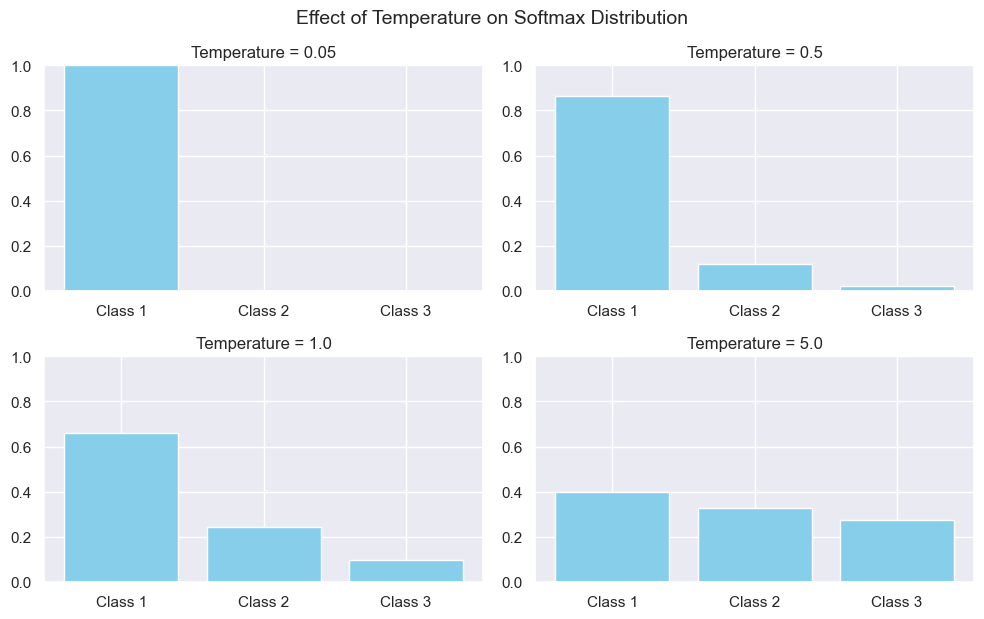

In [ ]:
# Raw logits (e.g., output of a neural network before softmax)
logits = torch.tensor([2.0, 1.0, 0.1])

# List of different temperatures to test
temperatures = [0.05, 0.5, 1.0, 5.0]

# Plotting setup
plt.figure(figsize=(10, 6))

for i, T in enumerate(temperatures):
    # Apply softmax with temperature
    probs = torch.softmax(logits / T, dim=0)

    # Print the probabilities
    print(f"Temperature = {T:.2f} → Probabilities: {probs.numpy()}")

    # Plot the distribution
    plt.subplot(2, 2, i + 1)
    plt.bar(range(len(probs)), probs.numpy(), color='skyblue')
    plt.title(f"Temperature = {T}")
    plt.ylim(0, 1)
    plt.xticks([0, 1, 2], ['Class 1', 'Class 2', 'Class 3'])

plt.tight_layout()
plt.suptitle("Effect of Temperature on Softmax Distribution", fontsize=14, y=1.03);

In [ ]:
prompt = 'In last'
tokens = tokenizer.encode(prompt).ids
tokens = torch.tensor(tokens, dtype=torch.int, device=device).unsqueeze(0)

model.eval()
with torch.no_grad():
    logits = model(tokens)

In [ ]:
logits.shape

torch.Size([1, 3, 10000])

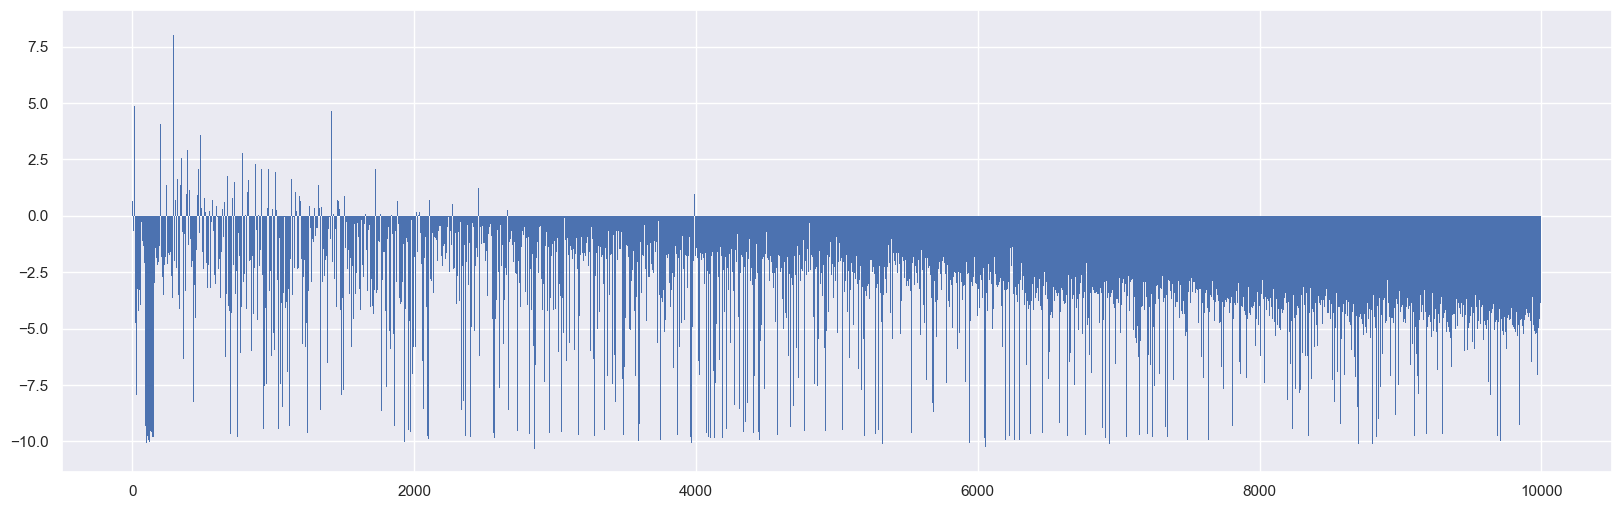

In [ ]:
plt.figure(figsize=(20, 6))
plt.bar(range(logits.shape[-1]), logits[0, -1].cpu(), width=1, edgecolor='none');

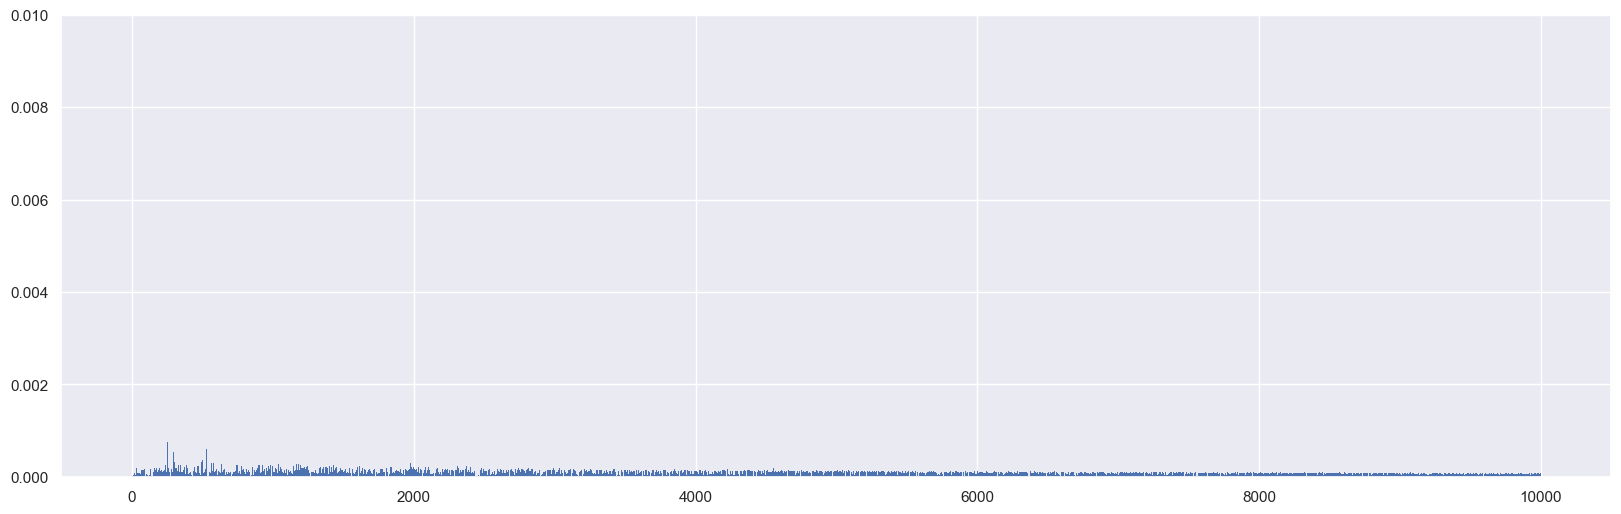

In [ ]:
T = 1.0
T = 0.5
T = 5.0
probs = torch.softmax(logits[0, -1]/T, dim=0)

plt.figure(figsize=(20, 6))
plt.bar(range(probs.shape[-1]), probs.cpu(), width=1, edgecolor='none')
plt.ylim(0, 0.01);

\### 🟡 `argmax` ➡ `top-k` & `multinomial`

In [ ]:
T = 5.
probs = torch.softmax(logits[0, -1]/T, dim=0)

In [ ]:
idx = torch.argmax(probs)
tokenizer.decode([idx.item()])

','

In [ ]:
topk_probs, topk_indices = torch.topk(probs, k=10)
print(topk_probs)
print(topk_indices)

tokenizer.decode(topk_indices.tolist())

tensor([0.0010, 0.0009, 0.0007, 0.0007, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005], device='cuda:0')
tensor([  13,  292,  252,  159,  529,  295, 1076,  243,   15, 1413],
       device='cuda:0')


', time day the one there night of. morning'

In [ ]:
idx = torch.multinomial(topk_probs, 1)
tokenizer.decode(topk_indices[idx].tolist())

' time'

In [ ]:
idx = torch.multinomial(probs, 1)
tokenizer.decode(idx.tolist()), probs[idx]

(' much', tensor([0.0005], device='cuda:0'))

In [ ]:
idx = torch.multinomial(topk_probs, 1)
idx, torch.gather(topk_indices, 0, idx) # == topk_indices[idx]

(tensor([1], device='cuda:0'), tensor([292], device='cuda:0'))

### 🟡 Final function

In [ ]:
prompts = [
    'In last',
    'Once upon',
    'Once upon a time',
    'One day, a little boy named TimTommy was a smart 3 year old, much smarter']

In [ ]:
item = 0
n_rep = 5
max_seq_len = 128
T = 0.9
top_k = 5

inputs = torch.tensor(tokenizer.encode(prompts[item]).ids, dtype=torch.int, device=device) # T
inputs = inputs.unsqueeze(0) # BxT
inputs = inputs.repeat(n_rep, 1)
print(inputs)
print(100*'-')

model.eval()
with torch.no_grad():
    for i in range(max_seq_len): # while
        logits = model(inputs)
        probs = torch.softmax(logits[:, -1, :]/T, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, k=top_k, dim=-1)
        ids = torch.multinomial(topk_probs, 1)
        ids = torch.gather(topk_indices, -1, ids)
        inputs = torch.cat((inputs, ids), dim=-1) # Bx(T+1)

generated_text = tokenizer.decode_batch(inputs.tolist())
for text in generated_text:
    pprint(text)
    print()

tensor([[   1, 2201, 2220],
        [   1, 2201, 2220],
        [   1, 2201, 2220],
        [   1, 2201, 2220],
        [   1, 2201, 2220]], device='cuda:0', dtype=torch.int32)
----------------------------------------------------------------------------------------------------
('In last, they were a big, a big tree. It was a big box. It was a big, a big '
 'tree, and a big, a little girl called it.\n'
 '\n'
 'One day, Lily went to her dad and asked her mommy. She said, "You can play '
 'with it. But it is that?" she said, "Yes, I have to make it. I will make it '
 'to help me. You can be more fun."\n'
 '\n'
 'The bird said, "I don\'t know what I have to be."\n'
 '\n'
 "The little girl nodded and said, â€œLetâ€™t worry, I'm going to")

('In last, there was a little girl. She loved playing on her mom, but it was a '
 'little girl named Lily. She loved to see a big house with her friends. One '
 "day, she saw a big, she had to make her mom's house with her room. She was "
 'sad because sh

In [ ]:
def generate(model, tokenizer, prompt, n_rep=5, max_seq_len=128, T=0.9, top_k=10, device='cuda', seed=42):
    # Tokenize the prompt and convert it to a tensor on the specified device (e.g., GPU)
    inputs = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device)  # Shape: [T]

    # Repeat the input prompt n_rep times to generate multiple sequences in parallel
    inputs = inputs.unsqueeze(0).repeat(n_rep, 1)  # Shape: [B, T] where B = n_rep

    # Set the model to evaluation mode
    model.eval()

    # Initialize a random number generator for sampling
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(seed)

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        # Continue generating tokens until reaching the maximum sequence length
        while inputs.shape[-1] < max_seq_len:
            # Forward pass: get logits from the model
            logits = model(inputs)  # Shape: [B, T, vocab_size]

            # Apply temperature scaling and softmax to get probabilities for the next token
            probs = torch.softmax(logits[:, -1, :] / T, dim=-1)  # Shape: [B, vocab_size]

            # Select the top_k tokens with the highest probabilities
            topk_probs, topk_indices = torch.topk(probs, k=top_k, dim=-1)  # Shape: [B, top_k]

            # Sample one token from the top_k candidates based on their probabilities
            ids = torch.multinomial(topk_probs, 1, generator=sample_rng)  # Shape: [B, 1]

            # Map the sampled indices back to the original token IDs
            ids = torch.gather(topk_indices, -1, ids)  # Shape: [B, 1]

            # Append the sampled tokens to the input sequence
            inputs = torch.cat((inputs, ids), dim=-1)  # Shape: [B, T+1]

    # Decode the generated sequences back into text
    generated_text = tokenizer.decode_batch(inputs.tolist())

    return generated_text

In [ ]:
def display_chat_style(prompt, generated_text, tokenizer, delay=0.03):
    """
    Display generated text in a token-by-token ChatGPT-like style:
    - prompt in green
    - generated continuation in blue
    """
    for i, full_text in enumerate(generated_text):
        print(colored(f"\n[Sample {i+1}]", "yellow"))
        input_ids = tokenizer.encode(prompt).ids
        full_ids = tokenizer.encode(full_text).ids

        # Split into prompt tokens and continuation
        prompt_tokens = full_ids[:len(input_ids)]
        continuation_tokens = full_ids[len(input_ids):]

        # Decode tokens separately
        prompt_text = tokenizer.decode(prompt_tokens)
        cont_tokens_text = [tokenizer.decode([tid]) for tid in continuation_tokens]

        # Print prompt in green
        sys.stdout.write(colored(prompt_text, 'green'))
        sys.stdout.flush()

        # Print continuation token-by-token in blue
        for token in cont_tokens_text:
            sys.stdout.write(colored(token, 'cyan'))
            sys.stdout.flush()
            time.sleep(delay)
        print()

In [ ]:
prompt = "In last"
generated = generate(model, tokenizer, prompt=prompt, n_rep=2, max_seq_len=128)
display_chat_style(prompt=prompt, generated_text=generated, tokenizer=tokenizer)


[Sample 1]
In last, there was a big, she would play with her house. She was three years old and it would find a toy and a little girl named Timmy. Lily loved to play with her house and put with a big box with his hands to the sky. One day, she saw a big, so much special bear.

The little girl smiled and said, "Don't worry, Lily, mom!" The bird looked up and said, "Don't like it. You need to play with the bird!"

As they looked around and smiled, "I am sorry!" Lily and said, "I'm a

[Sample 2]
In last time, the little bird was time, a little girl named Lily and her dad went to play with her family. Timmy saw the park, a little girl named Timmy was very sad. 

The little boy was sad and said, "It's so he is too, can play!" Timmy asked, and her friends and they could take her friends. Timmy said he wanted to help her and play with his toys to the sun.

Timmy asked the bear. Timmy said they decided to go back. 

When she saw the park, she was a little girl named Lily. She was very excited

### 🟡 `beam search`

In [ ]:
def beam_search_generate_custom(model, tokenizer, prompt, beam_width=3, max_seq_len=256, device="cuda"):
  # Tokenize the prompt and convert it to a tensor on the specified device (e.g., GPU)
  input_ids = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device).unsqueeze(0) # Shape: [B, T]

  end_token_id = tokenizer.token_to_id('<|endoftext|>') # end_token_id

  beams = [(input_ids, 0.0)] # (input_tensor, score)

  # Set the model to evaluation mode
  model.eval()

  # Disable gradient calculation for faster inference
  with torch.no_grad():
    # Continue generating tokens until reaching the maximum sequence length
    while beams[0][0][0].shape[-1] < max_seq_len:
        candidates = []
        for seq, score in beams:

            if seq[0, -1].item() == end_token_id:
                candidates.append((seq, score))
                continue
            # Forward pass: get logits from the model
            logits = model(seq)  # Shape: [B, T, vocab_size]

            # Apply softmax to get probabilities for the next token
            probs = torch.log(torch.softmax(logits[:, -1, :], dim=-1)) # Shape: [B, vocab_size]
            # probs = F.log_softmax(logits[:, -1, :], dim=-1) # Shape: [B, vocab_size]

            # Select the top_k tokens with the highest probabilities
            topk_probs, topk_indices = torch.topk(probs, beam_width, dim=-1)  # Shape: [B, top_k] where top_k = beam_width

            # For each top-k token, create a new candidate sequence by appending the token
            # and update its cumulative log-probability score
            for log_prob, token_id in zip(topk_probs[0], topk_indices[0]):
                new_seq = torch.cat([seq, token_id.view(1, 1)], dim=1)
                new_score = score + log_prob.item()
                candidates.append((new_seq, new_score))

        # Keep the top `beam_width` sequences with the highest cumulative log-probabilities
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # If all beams have ended with the end-of-text token, stop early (early stopping)
        if all(seq[0, -1].item() == end_token_id for seq, _ in beams):
            break

  # Retrieve the best token sequence from the top beam and decode it back into text
  generated_text = tokenizer.decode(beams[0][0][0].tolist())
  return generated_text

In [ ]:
prompt = 'in last night'
generated_text = beam_search_generate_custom(model, tokenizer, prompt, beam_width=3, max_seq_len=256, device="cuda")

display(HTML(f"<span style='color: cyan;'>{prompt}</span><span style='color: White;'>{generated_text[len(prompt):]}</span>"))

### 🟡 `beam search` & `n-gram`

In [27]:
def has_repeat_ngram(token_sequence, n):
  """
    Checks whether the given token sequence contains any repeated n-grams.

    Args:
        token_sequence (list of int): The list of token IDs to check.
        n (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).

    Returns:
        bool: True if a repeated n-gram is found, otherwise False.
  """
  if len(token_sequence) < n:
      return False
  seen = set()
  for i in range(len(token_sequence) - n + 1):
      ngram = tuple(token_sequence[i:i + n])
      if ngram in seen:
          return True
      seen.add(ngram)
  return False

In [ ]:
def beam_search_generate_custom(model, tokenizer, prompt, beam_width=3, max_seq_len=50, ngram_size=3, device="cpu"):
  # Tokenize the prompt and convert it to a tensor on the specified device (e.g., GPU)
  input_ids = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device).unsqueeze(0) # Shape: [B, T]

  end_token_id = tokenizer.token_to_id('<|endoftext|>') # end_token_id

  beams = [(input_ids, 0.0)] # (input_tensor, score)

  # Set the model to evaluation mode
  model.eval()

  # Disable gradient calculation for faster inference
  with torch.no_grad():
    # Continue generating tokens until reaching the maximum sequence length
    while beams[0][0][0].shape[-1] < max_seq_len:
      # Initialize the list of candidate sequences for the next beam step
      candidates = []
      for seq, score in beams:
        if seq[0, -1].item() == end_token_id:
            candidates.append((seq, score))
            continue
        # Forward pass: get logits from the model
        logits = model(seq) # Shape: [B, T, vocab_size]

        # Apply softmax to get probabilities for the next token
        probs = torch.log(torch.softmax(logits[:, -1, :], dim=-1)) # Shape: [B, vocab_size]
        # probs = F.log_softmax(logits[:, -1, :], dim=-1) # Shape: [B, vocab_size]

        # Select the top_k tokens with the highest probabilities
        topk_probs, topk_indices = torch.topk(probs, k=beam_width * 2, dim=-1)  # Shape: [B, 2*top_k] where top_k = beam_width

        # For each top-k token, create a new candidate sequence by appending the token
        # and update its cumulative log-probability score
        added = 0
        for log_prob, token_id in zip(topk_probs[0], topk_indices[0]):
            new_seq = torch.cat([seq, token_id.view(1, 1)], dim=1)
            token_list = new_seq[0].tolist()

            # Skip this candidate if adding the new token would create a repeated n-gram
            if has_repeat_ngram(token_list, n=ngram_size):
                continue

            new_score = score + log_prob.item()
            candidates.append((new_seq, new_score))
            added += 1

            # Stop adding candidates once the beam width limit is reached
            if added >= beam_width:
                break

      if not candidates:
          break

      # Keep the top `beam_width` sequences with the highest cumulative log-probabilities
      beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]

      # If all beams have ended with the end-of-text token, stop early
      if all(seq[0, -1].item() == end_token_id for seq, _ in beams):
          break

  # Retrieve the best token sequence from the top beam and decode it back into text
  generated_text = tokenizer.decode(beams[0][0][0].tolist())
  return generated_text

In [ ]:
prompt = 'in last night'
generated_text = beam_search_generate_custom(model, tokenizer, prompt, beam_width=3, max_seq_len=256, ngram_size=3, device="cuda")

display(HTML(f"<span style='color: cyan;'>{prompt}</span><span style='color: White;'>{generated_text[len(prompt):]}</span>"))

### 🟡 `top-k` & `multinomial` `n_rep` & `End_Of_token`

In [ ]:
def generate(model, tokenizer, prompt, n_rep=5, max_seq_len=128, T=0.9, top_k=10, device='cuda', seed=42):
  # Tokenize the prompt and convert it to a tensor on the specified device (e.g., GPU)

    inputs = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device)  # [T]

    # Repeat the input prompt n_rep times to generate multiple sequences in parallel
    inputs = inputs.unsqueeze(0).repeat(n_rep, 1)  # Shape: [B, T] where B = n_rep

    # Set the model to evaluation mode
    model.eval()

    end_token_id = tokenizer.token_to_id('<|endoftext|>')
    finished = torch.zeros(n_rep, dtype=torch.bool, device=device)  # [B] where B = n_rep

    # Initialize a random number generator for sampling
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(seed)

    # Disable gradient calculation for faster inference
    with torch.no_grad():
      # Continue generating tokens until reaching the maximum sequence length
      while inputs.shape[-1] < max_seq_len and not finished.all():
        # Forward pass: get logits from the model
        logits = model(inputs)  # Shape: [B, T, vocab_size]

        # Apply temperature scaling and softmax to get probabilities for the next token
        probs = torch.softmax(logits[:, -1, :] / T, dim=-1)   # Shape: [B, vocab_size]

        # Select the top_k tokens with the highest probabilities
        topk_probs, topk_indices = torch.topk(probs, k=top_k, dim=-1)  # Shape: [B, top_k]

        # Sample one token from the top_k candidates based on their probabilities
        ids = torch.multinomial(topk_probs, 1, generator=sample_rng)  # Shape: [B, 1]

        # Map the sampled indices back to the original token IDs
        ids = torch.gather(topk_indices, -1, ids)  # Shape: [B, 1]

        # Update finished flags
        finished |= (ids.squeeze(1) == end_token_id)

        # For finished sequences, we append the end_token_id repeatedly to maintain shape
        ids[finished.unsqueeze(1)] = end_token_id

        # Append the sampled tokens to the input sequence
        inputs = torch.cat((inputs, ids), dim=-1)  # Shape: [B, T+1]

    # Cut off everything after the first occurrence of end_token_id
    final_outputs = []
    for sequence in inputs.tolist():
        if end_token_id in sequence[1:]:
          end_index = sequence[1:].index(end_token_id)
          final_outputs.append(sequence[:end_index+1])
        else:
            final_outputs.append(sequence)

    # generated_text = tokenizer.decode_batch(inputs.tolist())
    generated_text = tokenizer.decode_batch(final_outputs)
    return generated_text

In [ ]:
prompt = 'in last'
generated_texts = generate(model, tokenizer, prompt, n_rep=3, max_seq_len=256, T=0.9, top_k=10, device='cuda', seed=43)
print('Generate top_k End_of_token:')
print()
for i, text in enumerate(generated_texts):
    display(HTML(f"<span style='color: yellow;'>Generated {i+1}:</span> <span style='color: cyan;'>{prompt}</span><span style='color: White;'>{text[len(prompt):]}</span>"))
    print('-'*150)

Generate top_k End_of_token:



------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


### 🟡 `top-P` & `multinomial` `n_rep`

In [ ]:
def generate_top_p(model, tokenizer, prompt, n_rep=3, max_seq_len=128, T=0.9, top_p=0.9, device='cuda', seed=42):
    # Tokenize the prompt and convert it to a tensor on the specified device (e.g., GPU)
    inputs = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device)  # Shape: [T]

    # Repeat the input prompt n_rep times to generate multiple sequences in parallel
    inputs = inputs.unsqueeze(0).repeat(n_rep, 1)  # Shape: [B, T] where B = n_rep

    # Set the model to evaluation mode
    model.eval()

    # Initialize a random number generator for sampling
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(seed)

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        # Continue generating tokens until reaching the maximum sequence length
        while inputs.shape[-1] < max_seq_len:
            # Forward pass: get logits from the model
            logits = model(inputs)  # Shape: [B, T, vocab_size]

            # Apply softmax to get probabilities for the next token
            probs = torch.softmax(logits[:, -1, :] / T, dim=-1)  # Shape: [B, vocab_size]

            # Select the top_P tokens with the highest probabilities
            sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)  # Shape: [B, top_k]
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            mask = cumulative_probs <= top_p
            mask[:, 0] = True
            cutoff = mask.sum(dim=-1)

            sampled_tokens = []
            for i in range(logits.size(0)):
                num_keep = cutoff[i].item()
                final_probs = sorted_probs[i, :num_keep]
                final_indices = sorted_indices[i, :num_keep]
                final_probs = final_probs / final_probs.sum()

                #Sample one token from the top_k candidates based on their probabilities
                idx = torch.multinomial(final_probs, num_samples=1, generator=sample_rng)
                sampled_token = final_indices[idx]
                sampled_tokens.append(sampled_token)

            ids = torch.stack(sampled_tokens)
            inputs = torch.cat((inputs, ids), dim=-1)  # Shape: [B, T+1]

    # Decode the generated sequences back into text
    generated_text = tokenizer.decode_batch(inputs.tolist())

    return generated_text

In [ ]:
prompt = 'in last'
generated_texts = generate_top_p(model, tokenizer, prompt, n_rep=3, max_seq_len=256, T=0.9, top_p=0.9, device='cuda', seed=42)

print('Generate top_p:')
print()
for i, text in enumerate(generated_texts):
    display(HTML(f"<span style='color: yellow;'>Generated {i+1}:</span> <span style='color: cyan;'>{prompt}</span><span style='color: White;'>{text[len(prompt):]}</span>"))
    print('-'*150)

Generate top_p:



------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


### 🟡 `top-P` & `multinomial` `n_rep` & `End_Of_token`

In [ ]:
def generate_top_p(model, tokenizer, prompt, n_rep=3, max_seq_len=256, T=0.9, top_p=0.9, device='cuda', seed=42):
    # Tokenize the prompt and convert it to a tensor on the specified device
    inputs = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device)  # Shape: [T]

    # Repeat the input prompt n_rep times to generate multiple sequences in parallel
    inputs = inputs.unsqueeze(0).repeat(n_rep, 1)  # Shape: [n_rep, T]

    end_token_id = tokenizer.token_to_id('<|endoftext|>')

    model.eval()
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(seed)

    # Track which sequences have finished (hit end token)
    finished = torch.zeros(n_rep, dtype=torch.bool, device=device)

    with torch.no_grad():
        while inputs.shape[-1] < max_seq_len and not all(finished):
            # Forward pass: get logits from the model
            logits = model(inputs)  # Shape: [n_rep, T, vocab_size]

            # Apply softmax to get probabilities for the next token
            probs = torch.softmax(logits[:, -1, :] / T, dim=-1)  # Shape: [n_rep, vocab_size]

            # Select the top_P tokens for each sequence in the batch
            sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            # Create mask for top-p sampling
            mask = cumulative_probs <= top_p
            # Ensure we always have at least one token
            mask[:, 0] = True

            # Find cutoff indices
            cutoff = mask.sum(dim=-1)

            # Prepare for batched sampling
            sampled_tokens = []
            for i in range(n_rep):
                if finished[i]:
                    # If sequence is finished, just pad with end token
                    sampled_tokens.append(end_token_id)
                    continue

                num_keep = cutoff[i]
                final_probs = sorted_probs[i, :num_keep]
                final_indices = sorted_indices[i, :num_keep]

                # Renormalize probabilities
                final_probs = final_probs / final_probs.sum()

                # Sample one token
                idx = torch.multinomial(final_probs, num_samples=1, generator=sample_rng)
                sampled_token = final_indices[idx]
                sampled_tokens.append(sampled_token)

                # Check if this sequence should finish
                if sampled_token == end_token_id:
                    finished[i] = True

            # Convert sampled tokens to tensor and add to inputs
            sampled_tokens = torch.tensor(sampled_tokens, device=device).unsqueeze(-1)
            inputs = torch.cat((inputs, sampled_tokens), dim=-1)

            # Early exit if all sequences are finished
            if all(finished):
                break

    # Cut off everything after the first occurrence of end_token_id
    final_outputs = []
    for sequence in inputs.tolist():
        if end_token_id in sequence[1:]:
          end_index = sequence[1:].index(end_token_id)
          final_outputs.append(sequence[:end_index+1])
        else:
            final_outputs.append(sequence)

    # Decode all generated sequences
    # generated_text = tokenizer.decode_batch(inputs.tolist())
    generated_text = tokenizer.decode_batch(final_outputs)
    return generated_text

In [ ]:
prompt = 'in last'
generated_text = generate_top_p(model, tokenizer, prompt, n_rep=3, max_seq_len=256, T=0.9, top_p=0.9, device='cuda', seed=42)
print('Generate top_p End_of_token:')
print()
for i, text in enumerate(generated_text):
    display(HTML(f"<span style='color: yellow;'>Generated {i+1}:</span> <span style='color: cyan;'>{prompt}</span><span style='color: White;'>{text[len(prompt):]}</span>"))
    print('-'*150)

Generate top_p End_of_token:



------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------------------------------


# 🔴 **Training Process 〽️**

In [ ]:
torch.manual_seed(1337)

seq_len = 128
train_set = TinyStoriesDataset(train_token_ids, seq_len)
valid_set = TinyStoriesDataset(valid_token_ids, seq_len)

batch_size = 192
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)#, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, pin_memory=True)#, num_workers=4)

print(f"📊 Number of Batches")
print(f"🔹 Train: {len(train_loader):,} batches")
print(f"🔹 Valid: {len(valid_loader):,} batches")

📊 Number of Batches
🔹 Train: 18,773 batches
🔹 Valid: 189 batches


In [ ]:
model = GPT(
    GPTConfig(
        max_seq_len=256,
        vocab_size=10_000,
        n_embd=128,
        n_layer=8,
        n_head=16
        )
    ).to(device)

print(model)
num_trainable_params(model)

GPT(
  (wte): Embedding(10000, 128)
  (wpe): Embedding(256, 128)
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=False)
        (c_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=128, out_features=512, bias=False)
        (down_proj): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (lnf): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=10000, bias=False)
)


2.889984

In [ ]:
learning_rate = 6e-4
weight_decay = 0.1
use_fused = True

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.95),
    weight_decay=weight_decay,
    fused=use_fused
    )

In [ ]:
prompts = [
    'In last night',
    'Once upon',
    'Once upon a time',
    'One day, a little boy named TimTommy was a smart 3 year old, much smarter']

num_return_sequences = 3
sent_test = [
    torch.tensor(tokens.ids, dtype=torch.long).unsqueeze(0).repeat(num_return_sequences, 1).to(device)
    for tokens in tokenizer.encode_batch(prompts)]
sent_test

temperature = 0.9
max_length = 32
top_k = 50

In [ ]:
torch.cuda.empty_cache()